In [197]:
# ! pip install "jax[tpu]>=0.2.16" -f https://storage.googleapis.com/jax-releases/libtpu_releases.html

# import jax.tools.colab_tpu
# jax.tools.colab_tpu.setup_tpu()

# 'COLAB_TPU_ADDR' in os.environ, 'google.colab' in str(get_ipython())

# import jax
# jax.devices()

In [198]:
# ! nvcc --version
# ! pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_releases.html

In [199]:
# from google.colab import drive
# drive.mount("/content/gdrive")

# %cd /content/gdrive/MyDrive/Projects/lensing-minimal/notebooks

# ! pip install einops scikit-image lenstronomy
# ! pip install git+https://github.com/adam-coogan/jaxinterp2d.git@master
# ! pip install flax numpyro distrax corner
# ! pip install objax

In [200]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import jax
import jax.numpy as jnp

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [201]:
from einops import rearrange

In [202]:
import matplotlib.pylab as pylab
import warnings
import matplotlib.cbook

from plot_params import params

warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [203]:
from jax.config import config
# config.update("jax_enable_x64", True)

In [204]:
import sys
sys.path.append("../")
from lensing_sim.lensing import LensingSim

In [205]:
import sys
# sys.path.append("../../gigalens/src/")

from gigalens.jax.inference import ModellingSequence
from gigalens.jax.model import ForwardProbModel, BackwardProbModel
from gigalens.model import PhysicalModel
from gigalens.jax.simulator import LensSimulator
from gigalens.simulator import SimulatorConfig
from gigalens.jax.profiles.light import sersic, interp
from gigalens.jax.profiles.mass import epl, shear, sie

In [430]:
plt.rcParams.update({
  "text.usetex": True,
})

In [207]:
cmap = 'magma'

In [215]:
n_xy = 400
n_sup = 1

n_xy_s = int(n_sup * n_xy)

## Hoag's object

In [216]:
# from PIL import Image
# from skimage.transform import rescale, resize, downscale_local_mean
# from urllib import request

# im_source = np.asarray(Image.open('hoag.jpg').convert('L'))
# im_source = resize(im_source, (n_xy, n_xy), anti_aliasing=False)
# im_source /= jnp.max(im_source)

# plt.imshow(im_source , cmap=cmap)

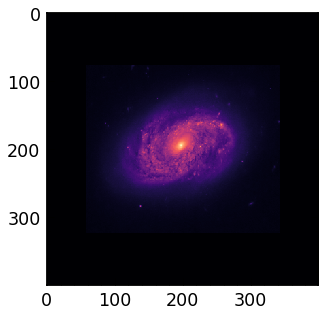

In [217]:
galaxy_url = "https://cdn.spacetelescope.org/archives/images/screen/potw2015a.jpg"
galaxy_name = "NGC2906"

# galaxy_url = "https://cdn.spacetelescope.org/archives/images/screen/heic0311a.jpg"
# galaxy_name = "NGC3982"

request.urlretrieve(galaxy_url, "{}.jpg".format(galaxy_name))
im_source = np.asarray(Image.open("{}.jpg".format(galaxy_name)).convert('L'))
im_source = im_source - np.min(im_source)
im_source = im_source / np.max(im_source)
im_source = np.pad(im_source, (256, 256))
im_source = resize(im_source, (n_xy_s, n_xy_s), anti_aliasing=True)
plt.imshow(im_source , cmap=cmap)

In [218]:
exp_time = 100

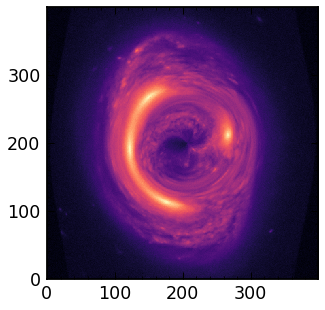

In [361]:
kernel = np.load('../gigalens/assets//psf.npy').astype(np.float32)
sim_config = SimulatorConfig(delta_pix=0.1 / (n_xy_s / 64), num_pix=n_xy_s, supersample=1, kernel=kernel)
coord_half = sim_config.delta_pix * sim_config.num_pix / 2
x_lims = [-coord_half, coord_half]
y_lims = [-coord_half, coord_half]
phys_model = PhysicalModel([sie.SIE(), shear.Shear()], [], [interp.Interp()])
lens_sim = LensSimulator(phys_model, sim_config, bs=1)

truth = [[
    {'theta_E': 1.3, 'e1': 0.2, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.0},
    {'gamma1': -0.02, 'gamma2': 0.02}
], [ 
    {'img': im_source, 'x_lims': x_lims, 'y_lims': y_lims}
]]

std_noise = 2.e-6
image = lens_sim.simulate(truth)
image += std_noise * np.random.randn(*image.shape)
image = image.reshape(-1, n_sup, image.shape[-1] // n_sup, n_sup).sum((-1, -3))

plt.imshow(image, origin='lower' , cmap=cmap)

In [362]:
np.median(image[image > 0.5 * image.max()] / std_noise)

72.404236

In [363]:
image.max() / std_noise

DeviceArray(121.93572, dtype=float32)

## Custom source

In [364]:
import sys
sys.path.append("../")

from lensing_sim.profiles import LightProfileSersic

In [365]:
from jax import vmap, jit
from einops import rearrange, repeat

In [366]:
# Lensed image

def render_lens(inputs):
    
    samples_src, samples_lens_params, x_lims, y_lims = inputs
    
    theta_E, theta_x, theta_y, e_1, e_2, gamma_1, gamma_2 = samples_lens_params
    
    truth = [[
        {'theta_E': theta_E, 'e1': e_1, 'e2': e_2, 'center_x': theta_x, 'center_y': theta_y},
        {'gamma1': gamma_1, 'gamma2': gamma_2}
    ], [ 
        {'img': samples_src, 'x_lims': x_lims, 'y_lims': y_lims}
    ]]

    image = lens_sim.simulate(truth)
    lens_sim.simulate(truth)
    
    return image

In [367]:
render_lens_vmapped = vmap(jit(render_lens))

## NeRF

In [368]:
def positional_encoding(inputs, positional_encoding_dims=4):
    batch_size, _ = inputs.shape
    inputs_freq = jax.vmap(
        lambda x: inputs * 2.0 ** x
    )(jnp.arange(positional_encoding_dims))
    periodic_fns = jnp.stack([jnp.sin(inputs_freq), jnp.cos(inputs_freq)])
    periodic_fns = periodic_fns.swapaxes(0, 2).reshape([batch_size, -1])
    periodic_fns = jnp.concatenate([inputs, periodic_fns], axis=-1)
    return periodic_fns

In [369]:
from typing import Any

import jax
import flax
import optax
from jax import lax
import flax.linen as nn
from flax.training import train_state, common_utils

In [370]:
num_dense_layers = 4
dense_layer_width = 256
add_positional_encoding = True
add_random_fourier = False
add_skip_connection = False
B = 5.

In [371]:
n_lens_params = 7

In [372]:
def initial_scale_tri_params(key):   
    ary = -7. * jnp.ones(int(n_lens_params * (n_lens_params + 1) / 2))
    ary = ary.at[:-n_lens_params].set(0.)
    return ary

def initial_loc_params(key):
    return jnp.array([1.5, 0., 0., 0.0, 0.0, 0.0, 0.0])

class NeRFModel(nn.Module):
    dtype: Any = jnp.float32

    @nn.compact
    def __call__(self, input_points):
        
        loc = self.param('loc_params', initial_loc_params)
        scale_tri = self.param('scale_tri_params', initial_scale_tri_params)
                
        # Apply positional encodings or random Fourier features (but not both) to the input points

        if add_positional_encoding and add_random_fourier:
            raise NotImplementedError("Can't have both positional encodings and RFFs")
            
        if add_positional_encoding:
            x = positional_encoding(input_points)
        elif add_random_fourier:
            x = nn.Dense(dense_layer_width, dtype=self.dtype, kernel_init=nn.initializers.normal(stddev=B / 2.), bias_init=nn.initializers.uniform(scale=1))(input_points)
            x = jnp.sin(2 * np.pi * x)
        else:
            x = input_points

        for i in range(num_dense_layers):
                                    
            # Fully-connected layer
            x = nn.Dense(
                dense_layer_width,
                dtype=self.dtype,
            )(x)
                        
            # Activation function
            x = nn.relu(x)
            
            if add_skip_connection: # Skip connection
                x = jnp.concatenate([x, input_points], axis=-1) if i in [4] else x

        x = nn.Dense(2, dtype=self.dtype)(x)
        return x, loc, scale_tri

In [373]:
def initialize_model(key, input_pts_shape):
    # Create an instance of the model
    model = NeRFModel()

    # Initialize the model parameters
    initial_params = jax.jit(model.init)(
        {"params": key},
        jnp.ones(input_pts_shape),
    )
    
    return model, initial_params["params"]

In [374]:
# Random Number Generator
key, rng = jax.random.split(jax.random.PRNGKey(np.random.randint(1000)))

# Initialize the Model
model, params = initialize_model(key, (n_xy_s * n_xy_s, 2))

In [375]:
input_to_network = jnp.ones((n_xy_s * n_xy_s, 2))

In [376]:
model.apply({"params": params}, input_to_network)

(DeviceArray([[-0.09949899,  0.09701963],
              [-0.09949899,  0.09701963],
              [-0.09949899,  0.09701963],
              ...,
              [-0.09949899,  0.09701963],
              [-0.09949899,  0.09701963],
              [-0.09949899,  0.09701963]], dtype=float32),
 DeviceArray([1.5, 0. , 0. , 0. , 0. , 0. , 0. ], dtype=float32),
 DeviceArray([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
               0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -7., -7., -7.,
              -7., -7., -7., -7.], dtype=float32))

In [377]:
"The model has {} parameters".format(sum(x.size for x in jax.tree_leaves(params)))

'The model has 202789 parameters'

In [378]:
theta_x_lims = theta_y_lims = x_lims
theta_x_coords, theta_y_coords = jnp.meshgrid(jnp.linspace(theta_x_lims[0], theta_x_lims[1], n_xy_s), jnp.linspace(theta_y_lims[0], theta_y_lims[1], n_xy_s))

coords = jnp.array([theta_x_coords, theta_y_coords])
image_input =  jnp.expand_dims(image, 0)

In [379]:
n_q_samples = 64

In [380]:
import distrax

In [381]:
import numpyro.distributions as dist

In [382]:
# lct = dist.transforms.ScaledUnitLowerCholeskyTransform()
lct = dist.transforms.SoftplusLowerCholeskyTransform()
# lct = dist.transforms.LowerCholeskyTransform()

scale_tri = lct(initial_scale_tri_params(key))
scale_tri

DeviceArray([[0.00091147, 0.        , 0.        , 0.        , 0.        ,
              0.        , 0.        ],
             [0.        , 0.00091147, 0.        , 0.        , 0.        ,
              0.        , 0.        ],
             [0.        , 0.        , 0.00091147, 0.        , 0.        ,
              0.        , 0.        ],
             [0.        , 0.        , 0.        , 0.00091147, 0.        ,
              0.        , 0.        ],
             [0.        , 0.        , 0.        , 0.        , 0.00091147,
              0.        , 0.        ],
             [0.        , 0.        , 0.        , 0.        , 0.        ,
              0.00091147, 0.        ],
             [0.        , 0.        , 0.        , 0.        , 0.        ,
              0.        , 0.00091147]], dtype=float32)

In [383]:
# ary = -7. * jnp.ones(int(n_lens_params * (n_lens_params + 1) / 2))
# ary = ary.at[:-n_lens_params].set(0.)

# lct(ary)
# lct.log_abs_det_jacobian(ary, lct(ary))

In [384]:
# jitter = jax.random.normal(key, shape=(2,)) * sim_config.delta_pix / 2.
# coords_rearranged = rearrange(coords, "c h w -> (h w) c") + jitter[jnp.newaxis, :]

In [385]:
import functools
from tensorflow_probability.substrates import jax as tfp
tfb = tfp.bijectors

@functools.partial(jax.jit, static_argnums=3)
def train_step(state, batch, key, learning_rate_fn):
    """Train Step"""
    # Unravel the inputs and targets from the batch
    inputs, targets = batch
    inputs = rearrange(inputs, "c h w -> (h w) c")
    
    # jitter = jax.random.normal(key, shape=(2,)) * sim_config.delta_pix / 4.
    jitter = jax.random.normal(key, shape=(1,)) * sim_config.delta_pix / 4.
    
    inputs = inputs + jitter[jnp.newaxis, :]
    
    key_lens, key_source = jax.random.split(key)
    
    # Compute the loss in a stateless manner
    def loss_fn(params):
        # Create the model function from the train state
        model_fn = lambda x: state.apply_fn({"params": params}, x)
        model_output, loc, scale_tri = model_fn(inputs)
                        
        model_output = rearrange(model_output, "(h w) mus -> mus (h w)", h=n_xy_s, w=n_xy_s)
        
        # Lens param loss
        
        scale_tri = lct(scale_tri)
        dist_lens = dist.MultivariateNormal(loc=loc, scale_tril=scale_tri)
        
        dist_prior_lens = dist.Uniform(low=jnp.array([1., -0.5, -0.5]), high=jnp.array([2., 0.5, 0.5]))
        dist_prior_ext = dist.Normal(loc=jnp.array([0., 0., 0., 0.]), scale=jnp.array([0.3, 0.3, .05, 0.05]))
        
        samples_lens = dist_lens.sample(key=key_lens, sample_shape=(n_q_samples,))
        
        loss_q_lens = jnp.sum(dist_lens.log_prob(samples_lens)) / n_q_samples                        
        loss_prior_lens = -jnp.sum(dist_prior_lens.log_prob(samples_lens[:, :-4])) / n_q_samples \
                            -jnp.sum(dist_prior_ext.log_prob(samples_lens[:, -4:])) / n_q_samples \

        # Source param loss
        mu, sigma = nn.softplus(model_output[0]), nn.softplus(model_output[1])
        dist_distrax = dist.Normal(mu, sigma)
        dist_prior = dist.HalfNormal(scale=1. * jnp.ones_like(mu))
        # dist_prior = dist.Uniform(low=0.0 * jnp.ones_like(mu), high=10. * jnp.ones_like(mu))
        
        samples = dist_distrax.sample(key=key_source, sample_shape=(n_q_samples,))
        # samples = repeat(im_source, "h w -> s (h w)", s=n_q_samples)
        
        loss_q = jnp.sum(dist_distrax.log_prob(samples)) / n_q_samples
        loss_prior = -jnp.sum(dist_prior.log_prob(samples)) / n_q_samples
                
        samples = rearrange(samples, "s (h w) -> s h w", h=n_xy_s, w=n_xy_s)
        
        x_lims = repeat(jnp.array([-coord_half, coord_half]) + jitter[0], "xx -> nq xx", nq=n_q_samples)
        y_lims = repeat(jnp.array([-coord_half, coord_half]) + jitter[0], "yy -> nq yy", nq=n_q_samples)
        
        lenses = render_lens_vmapped((samples, samples_lens, x_lims, y_lims))
        lenses = lenses.reshape(lenses.shape[0], lenses.shape[-1] // n_sup, n_sup, lenses.shape[-1] // n_sup, n_sup).sum((-1, -3))
        
        # Compute log-probability
        loss_mse = -jnp.sum(dist.Normal(targets, std_noise).log_prob(lenses)) / n_q_samples
            
        return  loss_q + loss_prior + loss_q_lens + loss_prior_lens + loss_mse
    
    # Transform the loss function to get the loss value and the gradients
    train_loss, gradients = jax.value_and_grad(loss_fn)(state.params)
    # Updated the model params and the optimizer state
    new_state = state.apply_gradients(grads=gradients)
    # Mean of train loss of the batch
    train_loss = jnp.mean(train_loss)
    # Compute PSNR
    train_psnr = -10.0 * jnp.log(train_loss) / jnp.log(10.0)
    
    lr = learning_rate_fn(state.step)
    
    return train_loss, train_psnr, new_state

In [386]:
learning_rate_init = 1e-3
learning_rate_variational = 1e-3
weight_decay = 1e-4
momentum = 0.5
optimizer_name = "adabelief"

In [387]:
train_epochs = 10000
warmup_steps = 2000
plot_every = 200

In [388]:
# lr_schedule = optax.constant_schedule(value=learning_rate_init)
# lr_schedule = optax.cosine_decay_schedule(init_value=learning_rate_init, decay_steps=train_epochs)
# lr_schedule_variational = optax.constant_schedule(value=learning_rate_variational)

lr_schedule = optax.warmup_cosine_decay_schedule(init_value=0, peak_value=learning_rate_init, warmup_steps=warmup_steps, decay_steps=train_epochs - warmup_steps)
lr_schedule_variational = optax.warmup_cosine_decay_schedule(init_value=0, peak_value=learning_rate_variational, warmup_steps=warmup_steps, decay_steps=train_epochs - warmup_steps)


In [389]:
coords.shape, image_input.shape

((2, 400, 400), (1, 400, 400))

In [390]:
def map_nested_fn(fn):
    '''Recursively apply `fn` to the key-value pairs of a nested dict'''
    def map_fn(nested_dict):
        return {k: (map_fn(v) if isinstance(v, dict) else fn(k, v)) for k, v in nested_dict.items()}
    return map_fn

In [391]:
# Random Number Generator
key, rng = jax.random.split(jax.random.PRNGKey(np.random.randint(1000)))

# Initialize the Model
model, params = initialize_model(key, (n_xy_s * n_xy_s, 2))

# Define the Optimizer
if optimizer_name == "adamw":
    optimizer = optax.adamw(learning_rate=lr_schedule, weight_decay=weight_decay)
elif optimizer_name == "sgdm":
    optimizer = optax.sgd(learning_rate=lr_schedule, momentum=momentum, nesterov=True)
elif optimizer_name == "adabelief":
    optimizer = optax.adabelief(learning_rate=lr_schedule)
else:
    raise NotImplementedError

optimizer_variational = optax.adabelief(learning_rate=lr_schedule_variational)

# # Create the Training State
label_fn = map_nested_fn(lambda k, _: "mlp" if k in ["w", "b"] else "var_params")
tx = optax.multi_transform({'mlp': optimizer, 'var_params': optimizer_variational}, label_fn)
params = params.unfreeze()
state = train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

# Function for executing the train and validation loop
def train_and_evaluate(state, train_step_fn, learning_rate_fn):
        
    train_loss_history, train_psnr_history, reconstructed_src_mu_history, reconstructed_src_std_history, reconstructed_lens_history = [], [], [], [], []
    loc_history, scale_tri_history = [], []
    key, rng = jax.random.split(jax.random.PRNGKey(np.random.randint(1000)))
    
    for epoch in tqdm(range(train_epochs)):
                
        train_batch = coords, image_input

        # Perform the Training Step
        key, rng = jax.random.split(key)
        train_loss, train_psnr, state = train_step_fn(state, train_batch, key, learning_rate_fn)
                      
        train_loss_history.append(np.asarray(np.mean(train_loss)))
        train_psnr_history.append(np.asarray(np.mean(train_psnr)))

        # Plot the result every plot interval
        if epoch % plot_every == 0:    
            
            model_fn = lambda x: state.apply_fn({"params": state.params}, x)
            model_output, loc, scale_tri = model_fn(rearrange(coords, "c h w -> (h w) c"))
            model_output = rearrange(model_output, "(h w) c -> c h w", h=n_xy_s, w=n_xy_s)
                        
            lenses = render_lens((nn.softplus(model_output[0]), loc, x_lims, y_lims))
            lenses = lenses.reshape(lenses.shape[-1] // n_sup, n_sup, lenses.shape[-1] // n_sup, n_sup).sum((-1, -3))

            reconstructed_lens_history.append(np.asarray(lenses.T))
            reconstructed_src_mu_history.append(np.asarray(nn.softplus(model_output[0])))
            reconstructed_src_std_history.append(np.asarray(nn.softplus(model_output[1])))
            
            loc_history.append(np.asarray(loc))
            scale_tri_history.append(np.asarray(scale_tri))
    
    hist = {
        "train_loss": train_loss_history,
        "train_psnr": train_psnr_history,
        "reconstructed_lens": reconstructed_lens_history,
        "reconstructed_src_mu": reconstructed_src_mu_history,
        "reconstructed_src_std": reconstructed_src_std_history,
        "loc_history": loc_history,
        "scale_tri_history": scale_tri_history
    }
    
    return state, hist

In [392]:
state, hist = train_and_evaluate(state, train_step, lr_schedule)

100%|██████████| 10000/10000 [14:02<00:00, 11.87it/s]


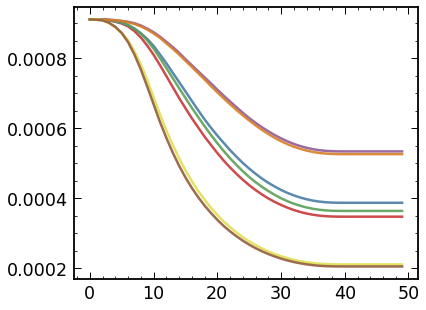

In [393]:
for j in range(n_lens_params):
    plt.plot([jnp.diag(lct(hist['scale_tri_history'][i]))[j] for i in range(len(hist['loc_history']))])
    
# plt.yscale("log")

In [394]:
# [jnp.diag(lct(hist['scale_tri_history'][i]))[0] for i in range(len(hist['loc_history']))]

In [395]:
jnp.diag(lct(hist['scale_tri_history'][-1]))

DeviceArray([0.00034759, 0.00038732, 0.00036407, 0.00053415, 0.00052638,
             0.0002111 , 0.00020535], dtype=float32)

In [396]:
hist['loc_history'][-1]

array([ 1.30049121e+00,  9.99763906e-02,  1.35443015e-05,  2.00455040e-01,
        1.00520335e-01, -1.97113100e-02,  2.02400219e-02], dtype=float32)

In [397]:
post_lens = dist.MultivariateNormal(loc=hist['loc_history'][-1], scale_tril=lct(hist['scale_tri_history'][-1]))
post_lens_samples = np.asarray(post_lens.sample(key=key, sample_shape=(10000,)))

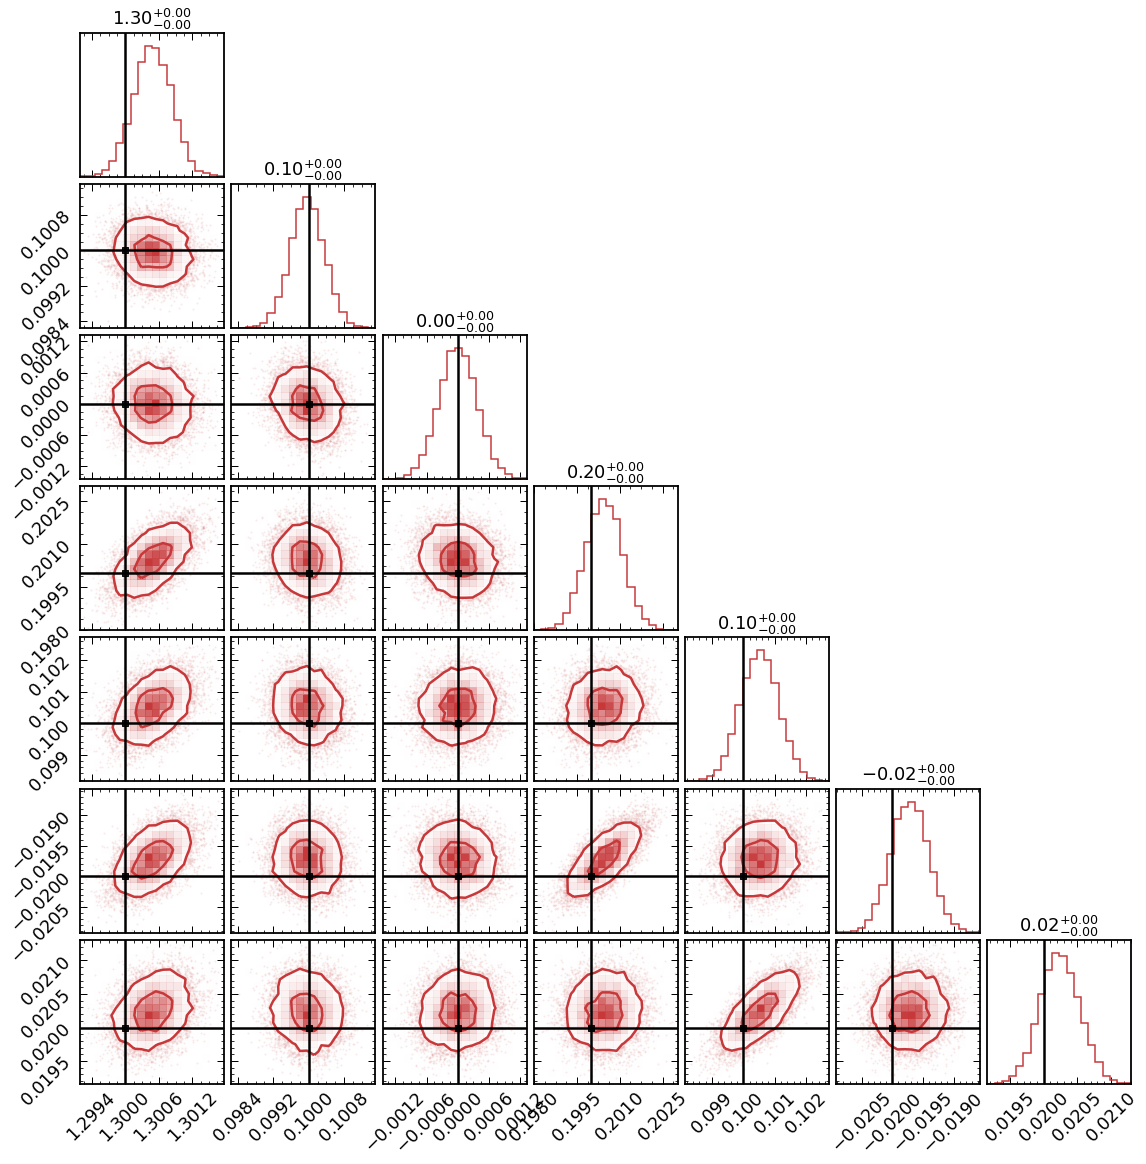

In [427]:
import corner

levels =  1.0 - np.exp(-0.5 *np.array([1.0, 2.0]) ** 2)

truths = [truth[0][0]['theta_E'], 
                     truth[0][0]['center_x'], 
                     truth[0][0]['center_y'], 
                     truth[0][0]['e1'],
                     truth[0][0]['e2'],
                     truth[0][1]['gamma1'],
                     truth[0][1]['gamma2']]

corner.corner(post_lens_samples, truths=truths,
                          bins=20, 
                          # quantiles=[0.16, 0.84],
                          show_titles=True,
                          color=cols_default[0],
                          levels=levels,
                          use_math_text=True, 
                          hist_kwargs={'alpha':1, 'lw':1.5}, 
                          alpha=0.1, truth_color='k',
                          # range=[1., 1., 1., 1., 1.]
);

In [447]:
labels = [r"$\theta_\mathrm{E}$",
          r"$\theta_x$",
          r"$\theta_y$",
          r"$\epsilon_x$",
          r"$\epsilon_y$",
          r"$\gamma_x$",
          r"$\gamma_y$",]          

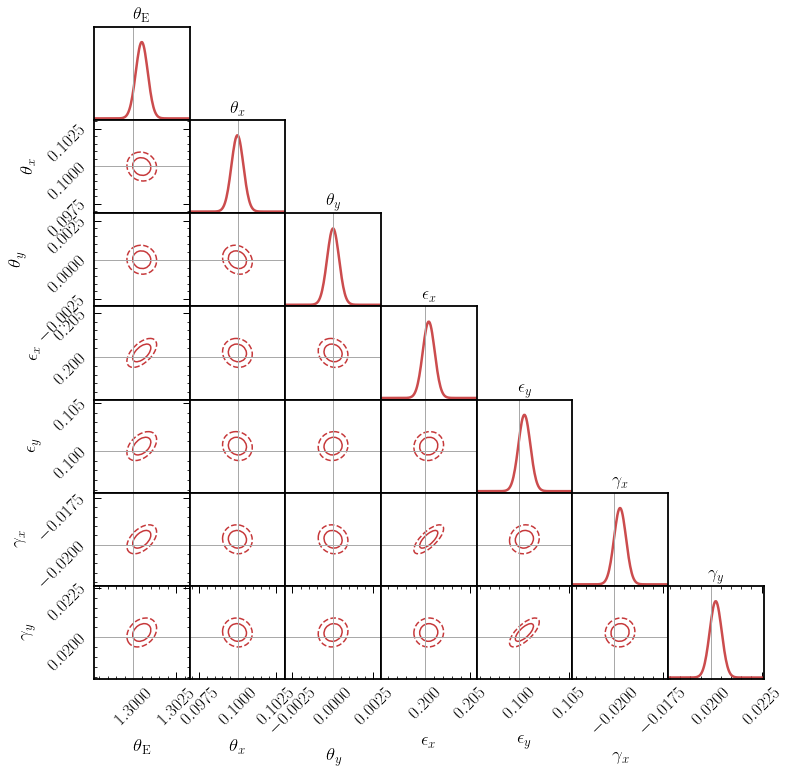

In [450]:
from matplotlib.patches import Ellipse

def plot_fisher_single(i ,cov, mu, ax, lims, truths, labels) :
    nb=128
    sigma=np.sqrt(cov[i,i])
    x_arr=mu[i]-8*sigma+16*sigma*np.arange(nb)/(nb-1.)
    p_arr=np.exp(-(x_arr-mu[i])**2/(2*sigma**2))
    ax.plot(x_arr,p_arr, color=cols_default[0])    
    ax.axvline(truths[i], color='darkgrey', lw=1)
    ax.set_xlim(lims[0][i], lims[1][i])
    ax.set_ylim(-0.02, 1.2)
    ax.set_title(labels[i])

def plot_fisher_two(i1, i2, cov, mu, ax, lims, truths, labels) :
    covar=np.zeros([2,2])
    covar[0,0]=cov[i1,i1]
    covar[0,1]=cov[i1,i2]
    covar[1,0]=cov[i2,i1]
    covar[1,1]=cov[i2,i2]
    sig0=np.sqrt(covar[0,0])
    sig1=np.sqrt(covar[1,1])

    w,v=np.linalg.eigh(covar)
    
    angle=180*np.arctan2(v[1,0],v[0,0])/np.pi
    a_1s=np.sqrt(2.3*w[0])
    b_1s=np.sqrt(2.3*w[1])
    a_2s=np.sqrt(6.17*w[0])
    b_2s=np.sqrt(6.17*w[1])

    centre=np.array([mu[i1],mu[i2]])
        
    e_1s=Ellipse(xy=centre,width=2*a_1s,height=2*b_1s,angle=angle, color=cols_default[0], lw=1.5)
    e_1s.set_fill(False)
    
    e_2s=Ellipse(xy=centre,width=2*a_2s,height=2*b_2s,angle=angle, ls='--', color=cols_default[0], lw=1.5)
    e_2s.set_fill(False)

    ax.add_artist(e_1s)
    ax.add_artist(e_2s)
    
    ax.axvline(truths[i1], color='darkgrey', lw=1)
    ax.axhline(truths[i2], color='darkgrey', lw=1)

    ax.set_xlim(lims[0][i1], lims[1][i1])
    ax.set_ylim(lims[0][i2], lims[1][i2])
    
    ax.set_xlabel(labels[i1])
    ax.set_ylabel(labels[i2])

def plot_fisher_all(mu, cov, lims, truths, labels): 
    n_params = len(mu)

    fig=plt.figure(figsize=(12, 12))
    plt.subplots_adjust(hspace=0, wspace=0)
    for i in np.arange(n_params):
        i_col=i
        for j in np.arange(n_params-i)+i :
            i_row=j
            iplot=i_col+n_params*i_row+1

            ax=fig.add_subplot(n_params,n_params,iplot)
            if i==j :
                plot_fisher_single(i, cov, mu, ax, lims, truths, labels)
            else :
                plot_fisher_two(i, j, cov, mu, ax, lims, truths, labels)

            if i_row!=n_params-1 :
                ax.get_xaxis().set_visible(False)

            if i_col!=0 :
                ax.get_yaxis().set_visible(False)

            if i_col==0 and i_row==0 :
                ax.get_yaxis().set_visible(False)
                
            ax.locator_params(nbins=2)
            [l.set_rotation(45) for l in ax.get_xticklabels()]
            [l.set_rotation(45) for l in ax.get_yticklabels()]

#     if n_params>1 : #Add labels in a separate plot
#         ax=fig.add_subplot(n_params,n_params,2)
#         ax.set_xlim([-1,1])
#         ax.set_ylim([-1,1])
#         for i in np.arange(len(labels)) :
#             ax.plot([-1,1],[-3,-3],color=lc[i],linestyle=ls[i],
#                     linewidth=lw[i],label=labels[i])
#         ax.legend(loc='upper left',frameon=False,fontsize=FS)
#         ax.axis('off')

#     if fname!="none" :
#         plt.savefig(fname,bbox_inches='tight')

    plt.show()

i = -1

chol = lct(hist['scale_tri_history'][i])

cov = np.dot(chol, chol.T)
mu = hist['loc_history'][i]

lims = [mu - 8 * np.sqrt(np.diag(cov)), mu + 8 * np.sqrt(np.diag(cov))]

plot_fisher_all(mu, cov, lims, truths, labels)

In [405]:
hist['loc_history'][-1]

array([ 1.30049121e+00,  9.99763906e-02,  1.35443015e-05,  2.00455040e-01,
        1.00520335e-01, -1.97113100e-02,  2.02400219e-02], dtype=float32)

In [323]:
# np.nan_to_num(np.array(hist["train_loss"]) / (n_xy * n_xy))[np.nan_to_num(np.array(hist["train_loss"]) / (n_xy * n_xy)) != 0.]

In [324]:
hist["train_loss"][-1] / (n_xy * n_xy)

-10.4163953125

(-15.0, 50.0)

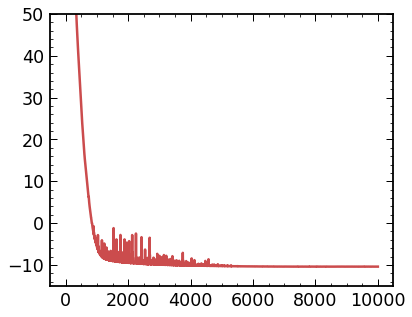

In [325]:
plt.plot(np.array(hist["train_loss"]) / (n_xy * n_xy))
plt.ylim(-15, 50)

In [326]:
# sigma = np.array(nn.softplus(hist["reconstructed_src_std"]))[-1, :]
# np.mean(sigma[sigma < 0.2])

In [327]:
# im = plt.imshow(np.sqrt(np.exp(np.array(hist["reconstructed_src_std"]))[-1, :]), cmap=cmap, vmax=0.1)
# cbar = plt.colorbar(im, ax=plt.gca())

In [328]:
from scipy.ndimage import gaussian_filter

In [329]:
# from lensing_sim.profiles import MassProfileSIE
# from lensing_sim.units import asctorad

# # x_d, y_d = MassProfileSIE(x_0=hst_param_dict["theta_x_0"] * lsi.D_l * asctorad,
# #                 y_0=hst_param_dict["theta_y_0"] * lsi.D_l * asctorad,
# #                 r_E=hst_param_dict["theta_E"] * lsi.D_l * asctorad,
# #                 q=hst_param_dict["q"],
# #                 ).deflection(lsi.x, lsi.y)

In [330]:
# oob_cond = ((lsi.x + x_d) > np.max(lsi.x)) + ((lsi.x + x_d) < np.min(lsi.x)) + \
# ((lsi.y + y_d) > np.max(lsi.y)) + ((lsi.y + y_d) < np.min(lsi.y))

In [331]:
# pixmax_cond = (im_source < 0.1 * im_source.max()) * oob_cond

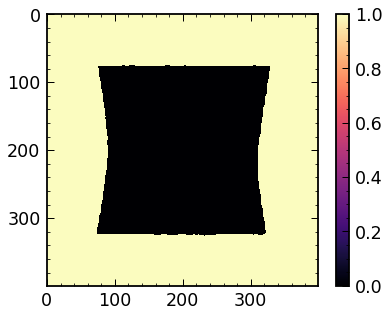

In [332]:
fig, ax = plt.subplots()
snr = ((hist["reconstructed_src_mu"][-1])) / ((hist["reconstructed_src_std"])[-1]) < 1
im = ax.imshow(snr, cmap=cmap)
cbar = fig.colorbar(im, ax=ax)

In [333]:
# plt.imshow(hist["reconstructed_src_std"][-1])

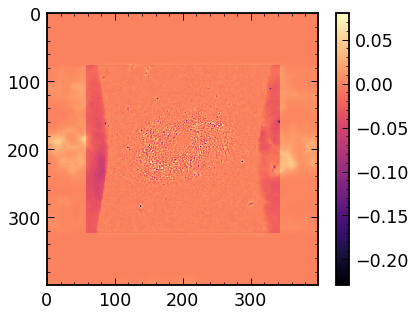

In [334]:
fig, ax = plt.subplots()
z_sc = ((hist["reconstructed_src_mu"][-1]) - im_source)
im = ax.imshow(z_sc, cmap=cmap)
cbar = fig.colorbar(im, ax=ax)

In [348]:
# fig, ax = plt.subplots()
# z_sc = np.abs((hist["reconstructed_src_mu"][-1]) - im_source) / (hist["reconstructed_src_std"][-1])
# im = ax.imshow(z_sc, cmap=cmap, vmin=0, vmax=10)
# cbar = fig.colorbar(im, ax=ax)

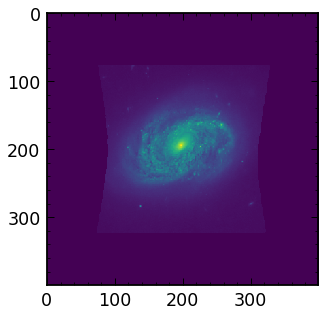

In [349]:
plt.imshow(im_source * ~snr)

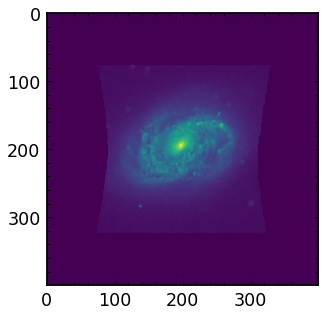

In [350]:
plt.imshow(hist["reconstructed_src_mu"][-1] * ~snr)

In [351]:
hist["reconstructed_src_mu"][-1][~snr].mean()

0.13274336

In [352]:
# fig, ax = plt.subplots()
# im = plt.imshow(np.abs(im_source - hist["reconstructed_src_mu"][-1]) / hist["reconstructed_src_std"][-1], vmin=0, vmax=3)
# cbar = fig.colorbar(im, ax=ax)

In [353]:
im_source[~snr].mean()

0.1327867192556716

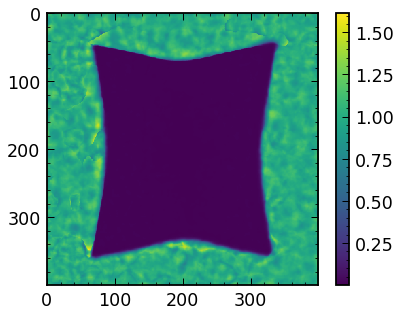

In [354]:
fig, ax = plt.subplots()
im = plt.imshow(hist["reconstructed_src_std"][-1])
cbar = fig.colorbar(im, ax=ax)

In [342]:
# fig, ax = plt.subplots()
# z_sc = ((hist["reconstructed_src_mu"][-1]) - im_source) / ((hist["reconstructed_src_std"])[-1])
# im = ax.imshow(z_sc, cmap=cmap, vmin=-2, vmax=2)
# cbar = fig.colorbar(im, ax=ax)

(-20.0, 20.0)

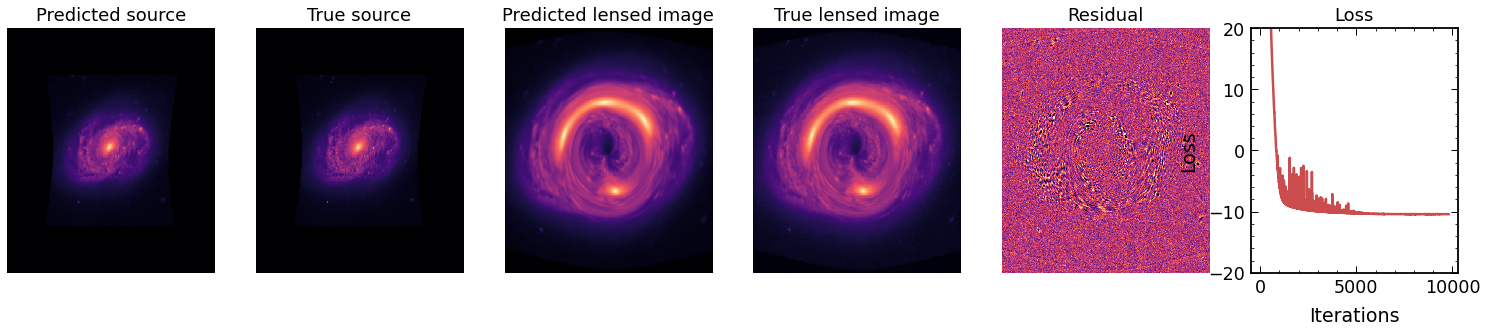

In [343]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(26, 4.5))

i = len(hist["reconstructed_src_mu"]) - 1

ax1.imshow((hist["reconstructed_src_mu"][i]) * ~snr, cmap=cmap, vmin=0, vmax=im_source.max(), aspect="auto")
# ax1.imshow(gaussian_filter(hist["reconstructed_src_mu"][i] * ~oob_cond, sigma=0.025 / pixel_size, truncate=8.), cmap=cmap, vmin=0, vmax=1, aspect="auto")
ax1.set_title(f"Predicted source")
ax1.axis("off")
ax2.imshow(im_source * ~snr, cmap=cmap, vmin=0, vmax=im_source.max(), aspect="auto")
ax2.set_title(f"True source")
ax2.axis("off")
ax3.imshow(hist["reconstructed_lens"][i], cmap=cmap, aspect="auto")
ax3.set_title(f"Predicted lensed image")
ax3.axis("off")
ax4.imshow(image_input[0].T, cmap=cmap, aspect="auto")
ax4.set_title(f"True lensed image")
ax4.axis("off")
# im = ax5.imshow((hist["reconstructed_src_mu"][i] - mnist_resized) / np.sqrt(np.exp(hist["reconstructed_src_std"][i])), cmap=cmap, vmin=-3, vmax=3)
im = ax5.imshow((hist["reconstructed_lens"][i] - image_input[0].T) / std_noise, cmap=cmap, aspect="auto", vmin=-5, vmax=5)
ax5.set_title(f"Residual")
ax5.axis("off")
ax6.plot(np.arange(plot_every * (i)), np.array(hist["train_loss"][:plot_every * (i)]) / (n_xy * n_xy))
ax6.set_title(f"Loss")
ax6.set_xlabel(f"Iterations")
ax6.set_ylabel(f"Loss")
ax6.set_ylim(-20, 20)

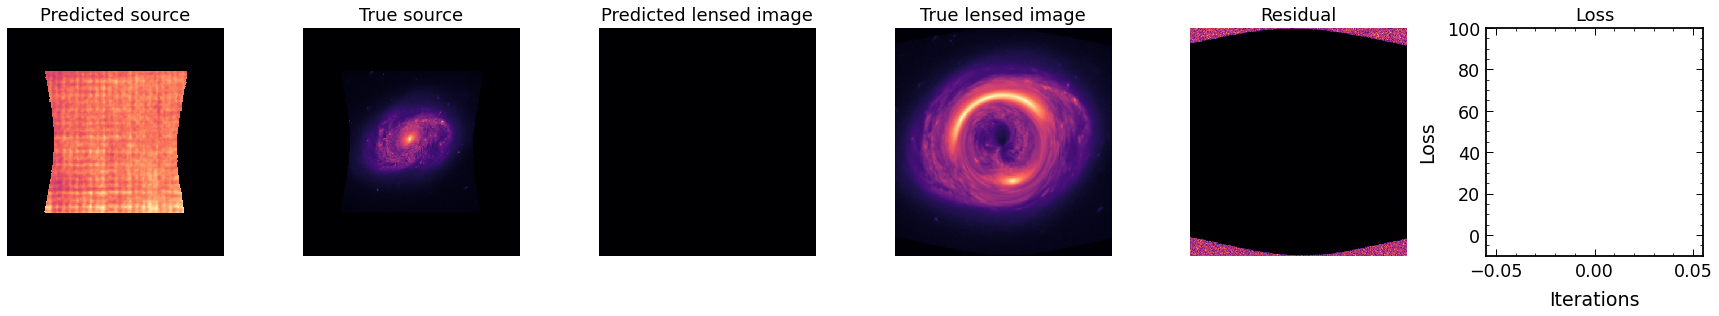

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

In [392]:
from celluloid import Camera

epoch = -1

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(24, 4.5))
camera = Camera(fig)

for i in range(len(hist["reconstructed_lens"])):
    ax1.imshow((hist["reconstructed_src_mu"][i]) * ~snr, cmap=cmap, vmin=0, vmax=1, aspect="auto")
    ax1.set_title(f"Predicted source")
    ax1.axis("off")
    ax2.imshow(im_source * ~snr, cmap=cmap, vmin=0, vmax=1, aspect="auto")
    ax2.set_title(f"True source")
    ax2.axis("off")
    ax3.imshow(hist["reconstructed_lens"][i], cmap=cmap, aspect="auto")
    ax3.set_title(f"Predicted lensed image")
    ax3.axis("off")
    ax4.imshow(image_input[0].T, cmap=cmap, aspect="auto")
    ax4.set_title(f"True lensed image")
    ax4.axis("off")
    im = ax5.imshow((hist["reconstructed_lens"][i] - image_input[0].T) / std_noise, cmap=cmap, aspect="auto", vmin=-5, vmax=5)
    ax5.set_title(f"Residual")
    ax5.axis("off")
    ax6.plot(np.arange(plot_every * (i)), np.array(hist["train_loss"][:plot_every * (i)]) / (n_xy * n_xy), color=cols_default[0])
    ax6.set_title(f"Loss")
    ax6.set_xlabel(f"Iterations")
    ax6.set_ylabel(f"Loss")
    ax6.set_ylim(-10, 100)
    # cbar = fig.colorbar(im, ax=ax5)
    plt.tight_layout();
    plt.show()
    camera.snap()

In [84]:
animation = camera.animate()
animation.save('render.gif', fps=10)

In [ ]:
# model_fn = lambda x: state.apply_fn({"params": state.params}, x)
# model_output = model_fn(rearrange(coords, "c h w -> 1 (c h w)"))
# model_output = rearrange(model_output, "1 (h w) -> 1 h w", h=n_xy, w=n_xy)
# plt.imshow(model_output[0])

## Truncated distribution tests

In [ ]:
from numpyro.distributions.flows import InverseAutoregressiveTransform
from numpyro.nn import AutoregressiveNN
from jax.example_libraries import stax

In [ ]:
def _make_iaf_args(input_dim, hidden_dims):
    _, rng_perm = jax.random.split(jax.random.PRNGKey(0))
    perm = jax.random.permutation(rng_perm, np.arange(input_dim))
    arn_init, arn = AutoregressiveNN(
        input_dim,
        hidden_dims,
        param_dims=[1, 1],
        permutation=perm,
        nonlinearity=stax.Elu,
    )
    _, init_params = arn_init(jax.random.PRNGKey(0), (input_dim,))
    return (functools.partial(arn, init_params),)

In [ ]:
InverseAutoregressiveTransform(_make_iaf_args(n_lens_params, [64]))

In [ ]:
td = dist.TransformedDistribution(dist.Normal(loc=jnp.zeros(n_lens_params), scale=jnp.ones(n_lens_params)), InverseAutoregressiveTransform(_make_iaf_args(n_lens_params, [64])))

In [ ]:
t = InverseAutoregressiveTransform(_make_iaf_args(n_lens_params, [64]))

In [ ]:
x = jax.random.normal(jax.random.PRNGKey(0), (n_lens_params,))
t(x)

TypeError: 'tuple' object is not callable

In [ ]:
from numpyro.distributions import constraints, transforms
import jax.random as random

num_flows = 3
dim = n_lens_params

flows = []
for i in range(num_flows):
    if i > 0:
        flows.append(transforms.PermuteTransform(np.arange(dim + 1)[::-1]))
    arn_init, arn = AutoregressiveNN(dim + 1, [dim + 1, dim + 1],
                                           permutation=np.arange(dim + 1),
                                           nonlinearity=stax.Elu)
    _, init_params = arn_init(jax.random.PRNGKey(0), (dim + 1,))
    functools.partial(arn, init_params)
    flows.append(InverseAutoregressiveTransform(arn))
    
transform = transforms.ComposeTransform(flows)
transform
transform(x)

TypeError: apply_fun() missing 1 required positional argument: 'inputs'